In [22]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.sparse import hstack
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
train_df = pd.read_json("../data/processed/IMDB_reviews_train_cleaned.json")
test_df = pd.read_json("../data/processed/IMDB_reviews_test.json")

In [5]:
train_df["is_spoiler"] = train_df["is_spoiler"].astype(int)
test_df["is_spoiler"] = test_df["is_spoiler"].astype(int)

In [6]:
for df in [train_df, test_df]:
    df["review_length"] = df["review_text"].apply(lambda x: len(str(x)))
    df["word_count"] = df["review_text"].apply(lambda x: len(str(x).split()))

prepare TF-IDF features

In [7]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_text = tfidf.fit_transform(train_df["review_text"])
X_test_text = tfidf.transform(test_df["review_text"])

In [8]:
numeric_features = ["polarity", "subjectivity", "review_length", "word_count"]
X_train_numeric = train_df[numeric_features].fillna(0)
X_test_numeric = test_df[numeric_features].fillna(0)

In [10]:
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(X_train_numeric)
X_test_numeric = scaler.transform(X_test_numeric)

C:\Users\alici\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [18]:
X_train = hstack([X_train_text, X_train_numeric])
X_test = hstack([X_test_text, X_test_numeric])

y_train = train_df["is_spoiler"]
y_test = test_df["is_spoiler"]

In [20]:
from lightgbm import LGBMClassifier
model = LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    learning_rate=0.05,
    num_leaves=31,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=5,
    n_estimators=500
)

model.fit(X_train, y_train)  # Just fit without early stopping



[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 120868, number of negative: 338256
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.253228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274786
[LightGBM] [Info] Number of da

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


C:\Users\alici\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\alici\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\lightgbm\basic.py:1238: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Accuracy: 0.7695631719259117
F1-score: 0.40252992997515247
AUC: 0.7338485636088026

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.94      0.86     84726
           1       0.63      0.30      0.40     30056

    accuracy                           0.77    114782
   macro avg       0.71      0.62      0.63    114782
weighted avg       0.75      0.77      0.74    114782



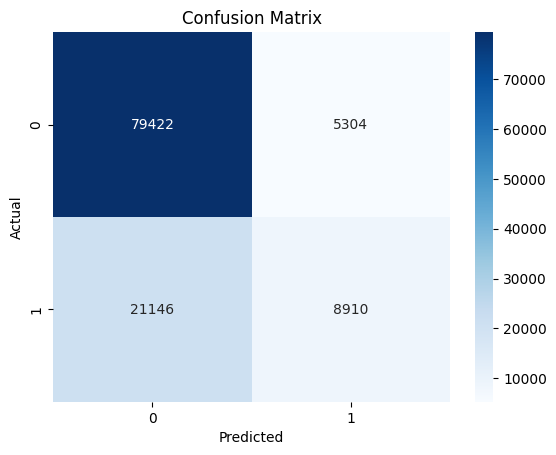

In [23]:
y_pred_prob = model.predict_proba(X_test)[:, 1]  # probability of being a spoiler
y_pred = (y_pred_prob > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()